In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define Rod_leak
glbar = 0.52*msiemens*cm**-2
El_rev = -74*mV

eqs_leak = '''
Ileak = glbar * (V-El_rev) : amp / metre**2
'''

In [4]:
# Photocurrent parameters
Idark = -40*pA
Tau1 = 50*ms
Tau2 = 450*ms
Tau3 = 800*ms
RodB = 3800*ms

eqs_input = '''
# input photocurrent
Ip = Idark + A*( 32*(1-exp(-t/Tau1)) - 33*(1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3)))/33: amp
A : amp
'''

In [17]:
# Define Rod_ih
Eh_rev = -32*mV
Vhalf_h = -82*mV
gh_bar = 2.5*msiemens*cm**-2
Sh = -5.33*mV
aoh = 1*Hz

eqs_h = '''
ah = 0.001*aoh*exp( (V-Vhalf_h)/(2*Sh) ) : Hz
bh = 0.001*aoh*exp( -(V-Vhalf_h)/(2*Sh) ) : Hz
tauh = 1/(ah+bh) : second
infh = ah*tauh : 1

dnh/dt = (infh-nh)/tauh : 1
gh = gh_bar * nh : siemens / metre**2
Ih = gh * (V-Eh_rev) : amp / metre**2
'''

In [18]:
# Morphology params
length = 10/np.pi*umeter
diam = 10*umetre

# Cylinder area = 2*pi*radius*length + 2*pi*radius^2
cell_area = np.pi*diam*length + 2*np.pi*diam**2/4
print(cell_area)
membrane_capacitance = 30*pfarad/cell_area
Ra = 200*ohm*cm

257.07963268 um^2


In [28]:
eqs_total = '''
# Transmembrane current
Im = 0*amp/metre**2 : amp / metre**2

#dV/dt = -(Ih + IKv + IKx + Ileak + ICa + ICl + IKCa + Ip/(cell_area)) / Cm : volt
dV/dt = -(Ih + Ileak + Ip/(cell_area)) / Cm : volt
'''
eqs = eqs_input + eqs_total + eqs_h + eqs_leak

In [29]:
# Set up simulation
defaultclock.dt = 1*ms
start_scope()

morpho = Cylinder(diameter=diam, n=1, length=length)
neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=membrane_capacitance, Ri=Ra, method='euler')
# Monitor voltage and Ip
M = StateMonitor(neuron, ['V', 'Ip', 'Ih', 'Ileak'],
                record=True, dt=10*ms)
# neuron.Ca = Cainf
neuron.V = -44*mV
neuron.A = 0*pA
# Initialize gating variables
# run(1*ms)
# neuron.nKx = neuron.infKx[:][0]
# neuron.mKv = neuron.infmKv[:][0]
# neuron.mCa = neuron.infmCa[:][0]
# neuron.hCa = neuron.infhCa[:][0]
neuron.nh = neuron.infh[:][0]

run(100*ms)
neuron.A = 40*pA
run(6000*ms)
neuron.A = 0*pA
run(2000*ms)

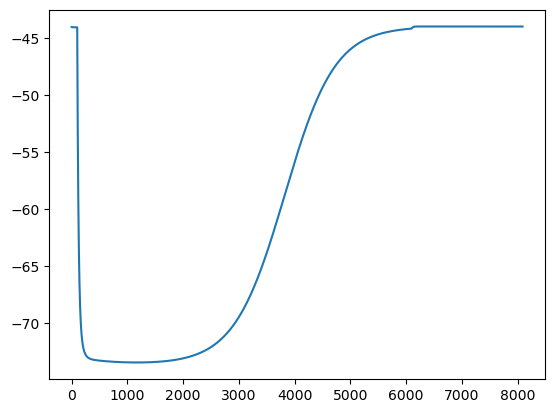

In [30]:
plot(M.t/ms, M.V[0]/mV)

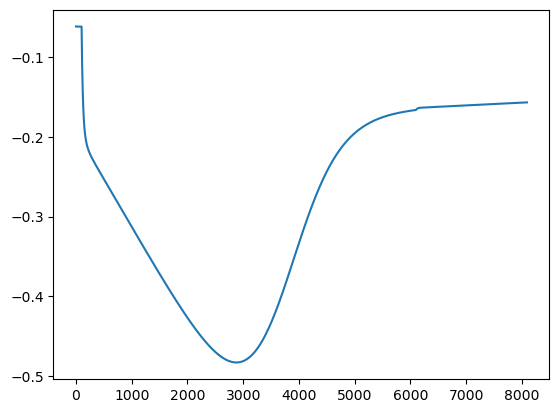

In [31]:
plot(M.t/ms, M.Ih[0]*cell_area/pA)